# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.877826,False,-0.818645
1,1.596462,True,5.323853
2,1.102643,True,5.879211
3,-0.809935,False,-2.353490
4,0.165712,True,6.053368
...,...,...,...
995,-0.016451,False,0.495271
996,-0.532815,True,4.265954
997,0.098311,False,-0.177560
998,0.747853,True,7.140920


<Axes: xlabel='v0'>

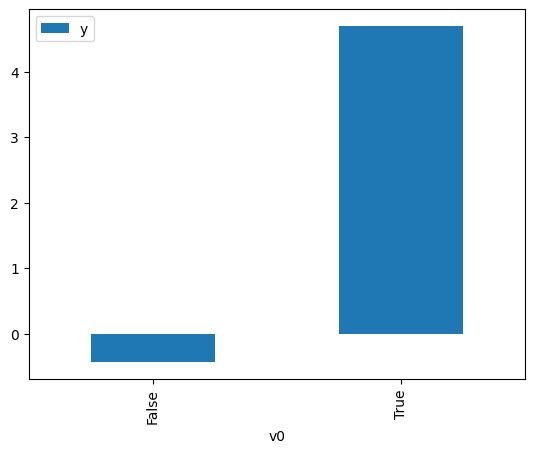

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

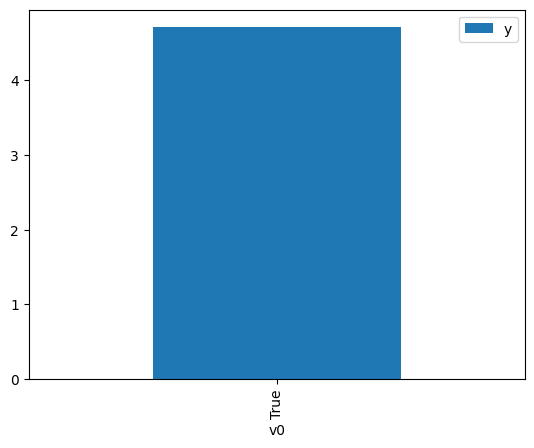

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.689034,False,1.436399,0.297689,3.359211
1,0.163822,False,-1.494918,0.450901,2.217784
2,-0.868287,False,-0.784906,0.750728,1.332041
3,-0.729991,False,0.599302,0.716744,1.395198
4,0.208477,False,-0.808020,0.437022,2.288215
...,...,...,...,...,...
995,-1.422697,False,-4.043144,0.858217,1.165207
996,1.483285,False,1.650789,0.134893,7.413270
997,-0.303306,False,0.556701,0.596554,1.676293
998,1.483285,False,1.650789,0.134893,7.413270


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.259218,True,4.604586,0.416874,2.398804
1,0.481431,True,6.478459,0.644954,1.550497
2,1.465073,True,6.146171,0.862408,1.159544
3,-0.537228,True,3.127503,0.334999,2.985081
4,-1.865022,True,0.527512,0.086473,11.564369
...,...,...,...,...,...
995,-0.118408,True,5.209289,0.460502,2.171545
996,-0.859146,True,3.940588,0.251432,3.977213
997,0.012812,True,5.278292,0.501724,1.993128
998,1.563029,True,7.079667,0.876400,1.141031


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.935
Model:                            OLS   Adj. R-squared (uncentered):              0.935
Method:                 Least Squares   F-statistic:                              7231.
Date:                Sun, 16 Jul 2023   Prob (F-statistic):                        0.00
Time:                        17:30:29   Log-Likelihood:                         -1445.8
No. Observations:                1000   AIC:                                      2896.
Df Residuals:                     998   BIC:                                      2905.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.3864      0.031     45.394      0.000       1.326       1.446
x2             4.9752      0.050     99.171      0.000       4.877       5.074
==============================================================================
Omnibus:                        0.689   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.709   Jarque-Bera (JB):                0.774
Skew:                          -0.039   Prob(JB):                        0.679
Kurtosis:                       2.889   Cond. No.                         1.72
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""